In [1]:
# I have decided that it is time I try my luck at building a simple app
# I have always been curious about finding a way to quickly run analysis on different subreddits to get an idea of what they are all about
# The best way to do this might be some form of sentiment analysis
# Thus, my goal is as follows: 
# Input subreddit link
# Output subreddit sentiment analysis based on the comments within each post
# Don't quite know where to start, but I'll go with beautiful soup first
# Beautiful soup is an excellent way to extract links and information from those links.

In [2]:
import bs4 as soup

In [ ]:
# I'll take a subreddit to start with: https://www.reddit.com/r/Gold/
# This subreddit is about exactly what you'd expect: gold. Perfoming a sentiment analysis on this reddit could allow us to get a picture of 
# how optimistic individuals are about Gold overtime

In [4]:
# The first step is probably to find out how to iterate through different reddit posts.
# Unfortunately, there is no iterative pattern to the links which can be used in order to extract all data from all posts
# Thankfully, reddit has its own API

In [ ]:
import requests
import time

headers = {
    'User-Agent': 'Gold/1.0'
}

url = 'https://www.reddit.com/r/Gold/new.json'
after = None
while True:
    params = {'limit': 100}
    if after:
        params['after'] = after
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        break
    data = response.json()
    time.sleep(2)

/opt/anaconda3/envs/Remote_Work_Env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [6]:
# As you can see, we now have a json file with all of the required information
# To process this json file, which is likely very complex, I need to determine exactly what I am after:
# The link and the title corresponding to that link
# Thankfully, this basically means that I just need to get the link, as the title is literally within link
# Yet, I'll also get the number of upvotes of the post, in addition to its (text) content

In [7]:
import json, pandas as pd, pprint, graphviz, ipytree
from json2txttree import json2txttree
from flatten_json import flatten
from anytree import Node, RenderTree

In [8]:
def clean_empty_lists(data):
    if isinstance(data, dict):
        return {k: clean_empty_lists(v) for k, v in data.items() if v != []}
    elif isinstance(data, list):
        return [clean_empty_lists(item) for item in data if item != []]
    return data

with open('reddit.json', 'r') as f:
    RedditGold = json.load(f)

RedditGold_clean = clean_empty_lists(RedditGold)

from json2txttree import json2txttree
print(json2txttree(RedditGold_clean))

└─  (object)
   ├─ "kind" (string)
   └─ "data" (object)
      ├─ "approved_at_utc" (number)
      ├─ "subreddit" (string)
      ├─ "selftext" (string)
      ├─ "author_fullname" (string)
      ├─ "saved" (number)
      ├─ "mod_reason_title" (number)
      ├─ "gilded" (number)
      ├─ "clicked" (number)
      ├─ "title" (string)
      ├─ "subreddit_name_prefixed" (string)
      ├─ "hidden" (number)
      ├─ "pwls" (number)
      ├─ "link_flair_css_class" (number)
      ├─ "downs" (number)
      ├─ "thumbnail_height" (number)
      ├─ "top_awarded_type" (number)
      ├─ "hide_score" (number)
      ├─ "name" (string)
      ├─ "quarantine" (number)
      ├─ "link_flair_text_color" (string)
      ├─ "upvote_ratio" (number)
      ├─ "author_flair_background_color" (number)
      ├─ "subreddit_type" (string)
      ├─ "ups" (number)
      ├─ "total_awards_received" (number)
      ├─ "media_embed" (object)
      ├─ "thumbnail_width" (number)
      ├─ "author_flair_template_id" (number)
     

In [ ]:
# So as we can see, the json file structure is very simple
# To navigate this structure, I will use a simple technique
# The dict structure I am aiming for is as follows:
# dict = {'Title': {'link':link,'ups':ups,'downs':downs}}

In [38]:
R_Gold_Data = {}

for post in data['data']['children']:
    title = post['data']['title']
    link = f"https://www.reddit.com{post['data']['permalink']}"
    ups = post['data']['ups']
    downs = post['data']['downs']
    
    if title not in R_Gold_Data:
        R_Gold_Data[title] = {
            'link': link,
            'ups': ups,
            'downs': downs
        }

In [48]:
R_Gold_Data = pd.DataFrame(R_Gold_Data).T

In [72]:
R_Gold_Data.head(2)

link  \
“The interests of a government in debt are not aligned with those of investors.” ~Axel Merk                                       https://www.reddit.com/r/Gold/comments/1kxroa8/the_interests_of_a_government_in_debt_are_not/   
Is Apmex a good place to buy pre33 gold coins and avoid fake pre33 gold I'm looking at a ngc graded $5 gold Liberty on apmex  https://www.reddit.com/r/Gold/comments/1kxrnvu/is_apmex_a_good_place_to_buy_pre33_gold_coins_and/   

                                                                                                                             ups  \
“The interests of a government in debt are not aligned with those of investors.” ~Axel Merk                                    2   
Is Apmex a good place to buy pre33 gold coins and avoid fake pre33 gold I'm looking at a ngc graded $5 gold Liberty on apmex   1   

                                                                                                                             downs  
“The interests of a government in debt are not aligned with those of investors.” ~Axel Merk                                      0  
Is Apmex a good place to buy pre33 gold coins and avoid fake pre33 gold I'm looking at a ngc graded $5 gold Liberty on apmex     0

In [ ]:
# Now that our data is ready, it is time to use beatiful soup to start extracting informaiton
# Reddit has a special feature that allows us to add .json to the end of a post. Using this, we don't have to go through the hassle of 
# Webscrappping through the html and css directly

In [69]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

R_Gold_Links = R_Gold_Data.loc[:, 'link'].reset_index()['link'].astype(str) + ".json"

In [ ]:
R_Gold_Links

0         https://www.reddit.com/r/Gold/comments/1kxroa8/the_interests_of_a_government_in_debt_are_not/.json
1     https://www.reddit.com/r/Gold/comments/1kxrnvu/is_apmex_a_good_place_to_buy_pre33_gold_coins_and/.json
2                 https://www.reddit.com/r/Gold/comments/1kxrb6f/4_full_sovereigns_and_1_half_soverign/.json
3                https://www.reddit.com/r/Gold/comments/1kxr99p/newest_pickups_over_the_past_few_weeks/.json
4        https://www.reddit.com/r/Gold/comments/1kxr8mb/wow_its_happening_gold_and_silver_legal_tender/.json
                                                       ...                                                  
95                                            https://www.reddit.com/r/Gold/comments/1kvtcmn/good_deal/.json
96                                   https://www.reddit.com/r/Gold/comments/1kvsz54/my_wife_bought_24k/.json
97                  https://www.reddit.com/r/Gold/comments/1kvpoyh/whats_the_deal_with_this_commercial/.json
98        https://w

In [176]:
import requests
import time
import json
from datetime import datetime

data_list = []
failed_urls = []

headers = {
    'User-Agent': 'GoldDataCollector/1.0'
}

def safe_int(value, default=0):
    """Safely convert value to integer, handling float strings and None"""
    try:
        return int(float(value)) if value else default
    except (ValueError, TypeError):
        return default

for i, url in enumerate(R_Gold_Links):
    try:
        print(f"Fetching {i+1}/{len(R_Gold_Links)}: {url.split('/comments/')[1][:15]}...")
        
        response = requests.get(url, headers=headers)
        
        # Handle rate limits
        if response.status_code == 429:
            retry_after = safe_int(response.headers.get('Retry-After'), 30)
            print(f"Rate limited! Waiting {retry_after} seconds...")
            time.sleep(retry_after)
            response = requests.get(url, headers=headers)
            
        if response.status_code == 200:
            try:
                data_list.append(response.json())
            except json.JSONDecodeError:
                print(f"Invalid JSON response from {url}")
                failed_urls.append(url)
        else:
            print(f"HTTP Error {response.status_code} on {url}")
            failed_urls.append(url)
            
        # Improved rate limit handling
        remaining = safe_int(response.headers.get('X-Ratelimit-Remaining'), 30)
        reset = safe_int(response.headers.get('X-Ratelimit-Reset'), 60)
        
        if remaining < 5:
            print(f"Approaching rate limit. Waiting {reset} seconds...")
            time.sleep(reset)
        else:
            time.sleep(max(1.0, reset/remaining))  # Dynamic delay
            
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {url}: {str(e)}")
        failed_urls.append(url)
        time.sleep(5)
    except Exception as e:
        print(f"Unexpected error processing {url}: {str(e)}")
        failed_urls.append(url)
        time.sleep(5)

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
with open(f'gold_data_{timestamp}.json', 'w') as f:
    json.dump(data_list, f, indent=2)

print(f"\nCompleted with {len(failed_urls)} failures out of {len(R_Gold_Links)}")
if failed_urls:
    print("Failed URLs:")
    for url in failed_urls:
        print(f"- {url}")

Fetching 1/100: 1kxroa8/the_int...
Fetching 2/100: 1kxrnvu/is_apme...
Fetching 3/100: 1kxrb6f/4_full_...
Fetching 4/100: 1kxr99p/newest_...
Fetching 5/100: 1kxr8mb/wow_its...
Fetching 6/100: 1kxqj6c/first_g...
Fetching 7/100: 1kxppic/help_i_...
Fetching 8/100: 1kxp5iu/first_g...
Fetching 9/100: 1kxow8t/18_cara...
Fetching 10/100: 1kxolvp/5g_gold...
Fetching 11/100: 1kxnqot/found_t...
Fetching 12/100: 1kxlmtc/look_at...
Fetching 13/100: 1kxle7l/i_want_...
Fetching 14/100: 1kxk35j/thrifte...
Fetching 15/100: 1kxj8u8/has_any...
Fetching 16/100: 1kxewmo/fl_gove...
Fetching 17/100: 1kxdfak/bars_vs...
Fetching 18/100: 1kxbg6e/advice_...
Fetching 19/100: 1kxbcx6/real_or...
Fetching 20/100: 1kxadfr/mail_ca...
Fetching 21/100: 1kx9lll/how_cou...
Fetching 22/100: 1kx9g1v/net_wor...
Fetching 23/100: 1kx8wfp/added_a...
Fetching 24/100: 1kx8iak/scrap_g...
Fetching 25/100: 1kx89p7/gold_is...
Fetching 26/100: 1kx80ya/is_this...
Fetching 27/100: 1kx7koz/what_of...
Fetching 28/100: 1kx6q22/storage...
F

In [ ]:
# data_list[1][1]['data']['children'][0]['data']['replies']['data']['children']
# data_list[1][1]['data']['children'][0]['data']['replies']['data']['children'][0]['data']['ups']
data_list[1][1]['data']['children'][0]['data']['replies']['data']['children'][0]['data']['downs']
# data_list[1][1]['data']['children'][0]['data']
# data_list[1][0]['data']['children'][0]['data']['title']

{'subreddit_id': 't5_2qmqp',
 'approved_at_utc': None,
 'author_is_blocked': False,
 'comment_type': None,
 'awarders': [],
 'mod_reason_by': None,
 'banned_by': None,
 'author_flair_type': 'text',
 'total_awards_received': 0,
 'subreddit': 'Gold',
 'author_flair_template_id': None,
 'likes': None,
 'replies': '',
 'user_reports': [],
 'saved': False,
 'id': 'murjga5',
 'banned_at_utc': None,
 'mod_reason_title': None,
 'gilded': 0,
 'archived': False,
 'collapsed_reason_code': None,
 'no_follow': True,
 'author': 'claimstoknowpeople',
 'can_mod_post': False,
 'created_utc': 1748464536.0,
 'send_replies': True,
 'parent_id': 't3_1kxrnvu',
 'score': 3,
 'author_fullname': 't2_cyf1o',
 'approved_by': None,
 'mod_note': None,
 'all_awardings': [],
 'collapsed': False,
 'body': 'Yes, it will be real from Apmex',
 'edited': False,
 'top_awarded_type': None,
 'author_flair_css_class': None,
 'name': 't1_murjga5',
 'is_submitter': False,
 'downs': 0,
 'author_flair_richtext': [],
 'author_pat

In [ ]:
# As one can see, the second [] determines which branch of the json we are in
# The first [] controls the post we are in
# The final [] after ['data']['replies']['data']['children'] determines post you are in at a given level
# That is to say, a reply will be [0] and a replay to a reply will be [1]

# The [0]['data']['body'] of: data_list[1][1]['data']['children'][0]['data']['body'] allows you to shift through these comments:

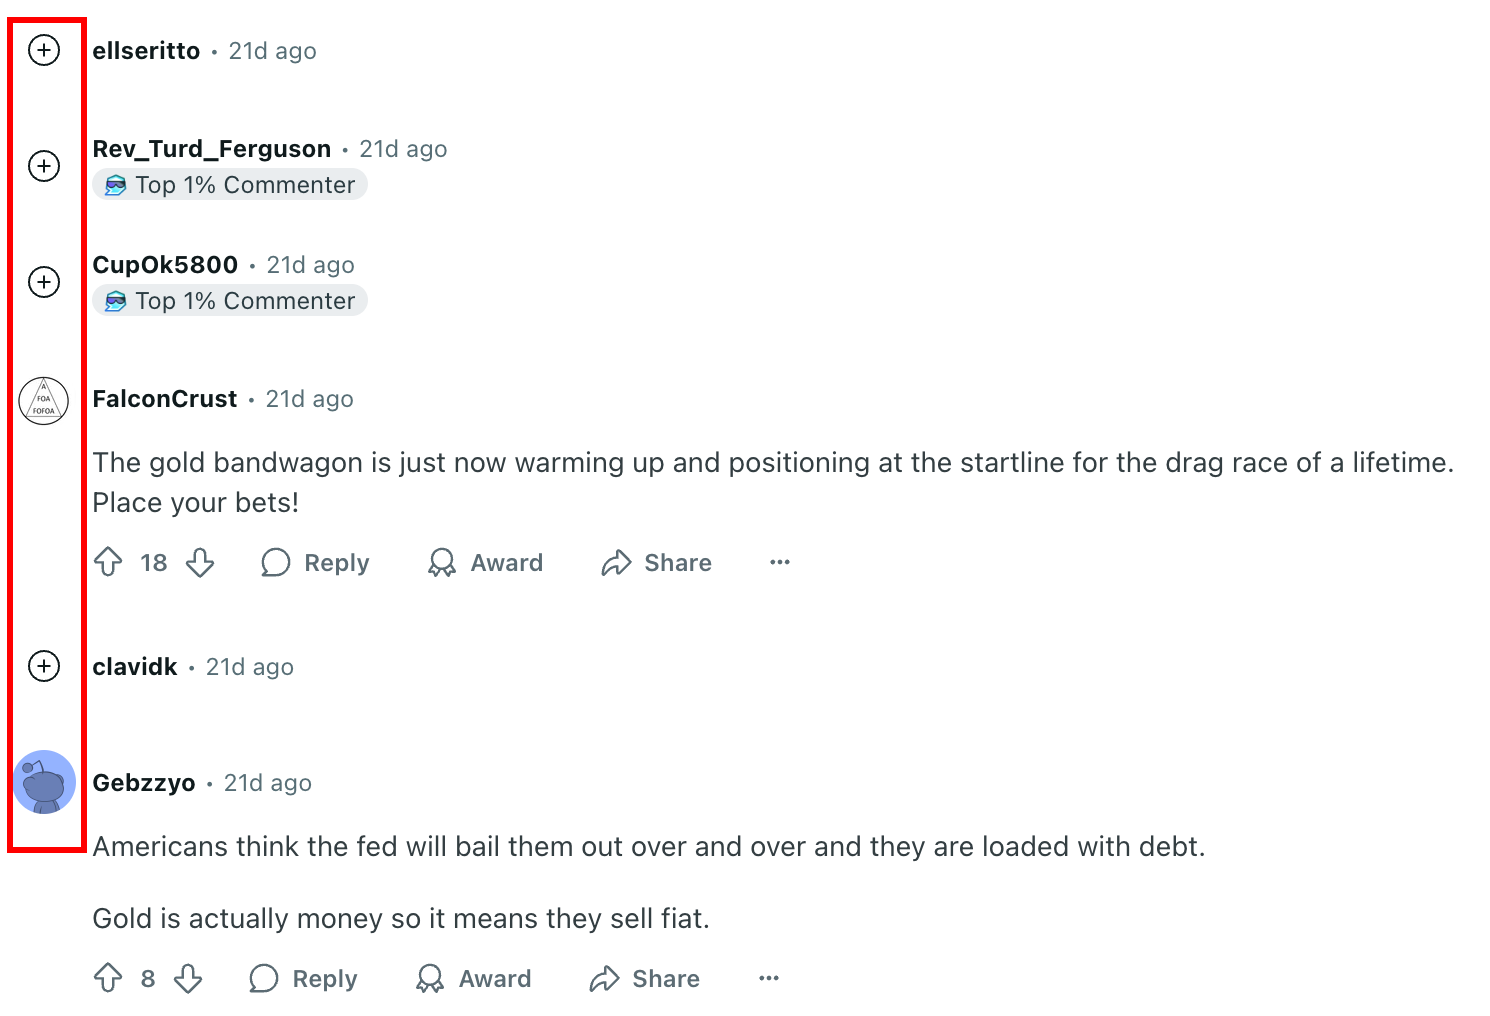

In [ ]:
# We need to extract all comments at all levels by post
# This is roughly the dict I am invisioning:
# dict = {
# 'title':
# {'post_reply':
# ['name':'name',
#  'ups':'ups',
#  'downs':'downs',
#  'replies': ['reply': ['name':'name','ups':'ups','downs':'downs','replies': ['reply repeats indefinetely']],
#              'reply': ['name':'name','ups':'ups','downs':'downs','replies': []]]}}

In [51]:
def process_comment(comment):
    """Helper function to process a single comment and its replies"""
    if comment['kind'] != 't1':  # Skip if not a comment
        return None
    
    comment_data = comment['data']
    comment_dict = {
        'name': comment_data['name'],
        'ups': comment_data.get('ups', 0),
        'downs': comment_data.get('downs', 0),
        'body': comment_data['body'],
        'replies': []
    }
    
    # Process replies if they exist
    if 'replies' in comment_data and comment_data['replies'] != '':
        try:
            replies = comment_data['replies']['data']['children']
            comment_dict['replies'] = [process_comment(reply) for reply in replies if process_comment(reply) is not None]
        except (KeyError, TypeError):
            pass
    
    return comment_dict

# Main processing
post_dict = {}
for post_data in data_list:
    # Extract title
    title = post_data[0]['data']['children'][0]['data']['title']
    
    # Initialize post entry
    post_dict[title] = {
        'post_reply': []
    }
    
    # Process all top-level comments
    comments = post_data[1]['data']['children']
    post_dict[title]['post_reply'] = [process_comment(comment) for comment in comments if process_comment(comment) is not None]

In [52]:
def flatten_comments(comments, post_title=None, parent_id=None, depth=0):
    rows = []
    for comment in comments:
        if comment is None:
            continue
            
        rows.append({
            'post_title': post_title,
            'comment_id': comment['name'],
            'parent_id': parent_id,
            'depth': depth,
            'ups': comment['ups'],
            'downs': comment['downs'],
            'body': comment['body'],
            'is_reply': (depth > 0)
        })
        
        if comment['replies']:
            rows.extend(flatten_comments(
                comment['replies'],
                post_title=post_title,
                parent_id=comment['name'],
                depth=depth+1
            ))
    return rows

all_comments = []

for post_title, post_data in post_dict.items():
    comments = post_data['post_reply']
    all_comments.extend(flatten_comments(comments, post_title=post_title))

comments_df = pd.DataFrame(all_comments)

comments_df = comments_df[['post_title', 'comment_id', 'parent_id', 'depth', 
                          'ups', 'downs', 'body', 'is_reply']]

In [53]:
comments_df.head()

post_title  \
0  Is Apmex a good place to buy pre33 gold coins and avoid fake pre33 gold I'm looking at a ngc graded $5 gold Liberty on apmex   
1  Is Apmex a good place to buy pre33 gold coins and avoid fake pre33 gold I'm looking at a ngc graded $5 gold Liberty on apmex   
2                                                                                         4 full sovereigns and 1 half soverign   
3                                                                              Wow it's happening, gold and silver legal tender   
4                                                                              Wow it's happening, gold and silver legal tender   

   comment_id   parent_id  depth  ups  downs  \
0  t1_murjga5        None      0    3      0   
1  t1_murk8hs        None      0    1      0   
2  t1_murjx42        None      0    1      0   
3  t1_murfs7j        None      0    5      0   
4  t1_murh5wg  t1_murfs7j      1    1      0   

                                                                                                           body  \
0                                                                               Yes, it will be real from Apmex   
1                                                                                             Got mine for $680   
2                                                                                   ![gif](giphy|A6soRJp32I7fy)   
3                                                           Wow this like the 10th post I have seen about this.   
4  Good job friend.  Some of us aren’t chronically online so we don’t see every single thing posted on Reddit 😄   

   is_reply  
0     False  
1     False  
2     False  
3     False  
4      True

In [ ]:
# Ok, NOW, we are finally ready to extract the all of the comments for a given post and run sentiment analysis on them
# Following this article: https://medium.com/@mohammed97ashraf/unsupervised-lexical-models-for-sentiment-prediction-using-python-e01576e8c9a6
# I have decided to use Sentiment Analysis with AFINN
# But, before we begin, I need to filter out posts so as to include only those which contain '[Gg]old'
# The easiest way to perform this analysis would be to first convert the dict we have into a pandas dataframe where everything is given
# A reply ID to correspond it to other superordinate posts

KeyError: 'comments'